# Rebecca's Data Challenge Week  5

The goal of today's data challenge is to predict whether a biospsied breast cell is cancerous based on a set of traits given about the cells.

The information given is:
1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)

A random forest classifier was trained on the data and performed with a true positive rate of 98%.

High uniformity of cell size scores appears to be the strongest predictor of malignant cells.

## Initial Exploration

The data is loaded into a pandas dataframe and various traits are plotted against one another will colors according to labels. Green is benign cells and red is cancerous cells.

In [2]:
#import packages
#packages for data exploration
import pandas as pd
import matplotlib.pyplot as plt
import math

In [3]:
#read the data table into a pandas dataframe
col_names = ['id_num','clump_thickness','uniformity_cell_size','uniformity_cell_shape','marginal_adhesion','single_cell_size','bare_nuclei','bland_chromatin','normal_nucleoli','mitoses','class']
df = pd.read_table('breast-cancer-wisconsin.data', delimiter = ',', header=None, names = col_names, na_values='?')

In [4]:
df.head()

,id_num,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [6]:
#drop any duplicate rows
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(699, 11)
(691, 11)


In [7]:
#spit into separte data sets for malignant and benign cells for convenience when plotting
mal = df.loc[df['class']==4]

In [8]:
ben = df.loc[df['class']==2]

In [9]:
#expore class balance by examining sizes of the labeled dataframes
mal.shape

(238, 11)

In [10]:
ben.shape

(453, 11)

In [11]:
#look for any missing values that may have to be dealt with
mal.isna().sum()

id_num                   0
clump_thickness          0
uniformity_cell_size     0
uniformity_cell_shape    0
marginal_adhesion        0
single_cell_size         0
bare_nuclei              2
bland_chromatin          0
normal_nucleoli          0
mitoses                  0
class                    0
dtype: int64

In [12]:
ben.isna().sum()

id_num                    0
clump_thickness           0
uniformity_cell_size      0
uniformity_cell_shape     0
marginal_adhesion         0
single_cell_size          0
bare_nuclei              14
bland_chromatin           0
normal_nucleoli           0
mitoses                   0
class                     0
dtype: int64

All these missing values lie in a single column. It may not be necessary to retain this column.

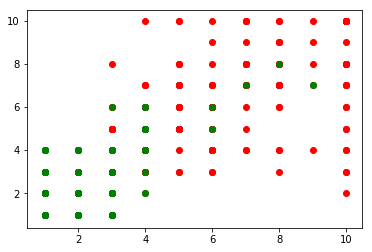

In [12]:
%plot two columns at a time to explore the data
%matplotlib inline
plt.scatter(mal['uniformity_cell_size'],mal['uniformity_cell_shape'],c='red')
plt.scatter(ben['uniformity_cell_size'],ben['uniformity_cell_shape'],c='green')
#it looks like these may be correlated
#benign cells have lower uniformity scores

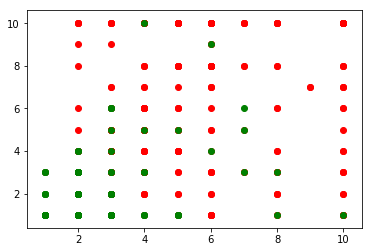

In [15]:
%matplotlib inline
plt.scatter(mal['single_cell_size'],mal['marginal_adhesion'],c='red')
plt.scatter(ben['single_cell_size'],ben['marginal_adhesion'],c='green')
#benign cells are smaller have have lower adhesion scores

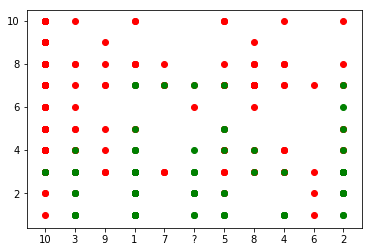

In [16]:

%matplotlib inline
plt.scatter(mal['bare_nuclei'],mal['bland_chromatin'],c='red')
plt.scatter(ben['bare_nuclei'],ben['bland_chromatin'],c='green')
#benign cells have more bare nuclei and less bland chromatin

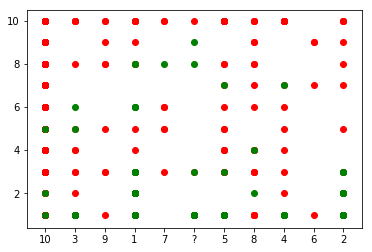

In [17]:
%matplotlib inline
plt.scatter(mal['bare_nuclei'],mal['normal_nucleoli'],c='red')
plt.scatter(ben['bare_nuclei'],ben['normal_nucleoli'],c='green')
#this combination is not predictive. Also not correlated.

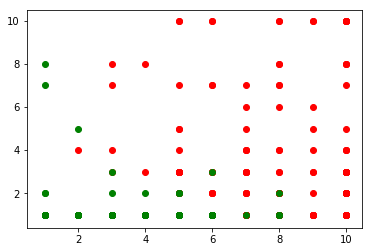

In [24]:
%matplotlib inline
plt.scatter(mal['clump_thickness'],mal['mitoses'],c='red')
plt.scatter(ben['clump_thickness'],ben['mitoses'],c='green')
#benign cells have low numbers of mitoses or small clump thicknesses.

## Data Cleaning

The data is relatively clean. But clearing up the correlated data and getting rid of the NA values is a good idea. The classes are somewhat unbalanced, but not very unbalanced, a standard random forest should be able to perform well on this.

In [28]:
def corr_df(x, corr_val):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''

    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if abs(val) >= corr_val:
                # Prints the correlated feature set and the corr val
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]

    # Drops the correlated columns
    for i in drops:
        col = x.iloc[:, (i+1):(i+2)].columns.values
        x = x.drop(col, axis=1)
    return x

In [31]:
mal['label']=1
ben['label']=0
df = pd.concat([ben,mal],axis=0)

/Users/rebeccareitz/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/rebeccareitz/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
df.shape

(699, 12)

In [44]:
df_cleaning = df.drop(['id_num','class','label'],axis=1)
df_cleaning.head()

,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1


In [43]:
labels = df['label']

In [52]:
df_clean = corr_df(df_cleaning, .75)

single_cell_size | uniformity_cell_size | 0.75
bland_chromatin | uniformity_cell_size | 0.76


In [53]:
df_clean.shape

(699, 7)

In [54]:
#So the column with all of the missing values got dropped. Just as well.
df_clean.head()

,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,bland_chromatin,normal_nucleoli,mitoses
0,5,1,1,1,3,1,1
1,5,4,4,5,3,2,1
2,3,1,1,1,3,1,1
3,6,8,8,1,3,7,1
4,4,1,1,3,3,1,1


In [55]:
df_to_model = pd.concat([df_clean,labels],axis=1)

In [56]:
df_to_model.shape

(699, 8)

## Build a model

A random forest was used. This model has very few initial assumptions but the results can be somewhat difficult to interpret.

In [72]:
#import some modeling packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df_clean, labels, test_size=.2)

In [61]:
clf = RandomForestClassifier(class_weight = 'balanced')

In [62]:
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [63]:
y_predict = clf.predict(X_test)

In [67]:
clf_confuse = confusion_matrix(y_test, y_predict)

In [73]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[80  5]
 [ 1 54]]


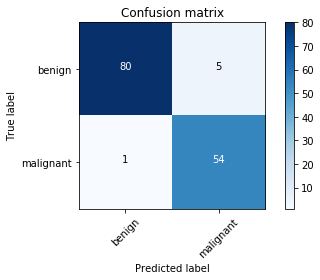

In [74]:
%matplotlib inline
plot_confusion_matrix(clf_confuse,classes = ['benign','malignant'])

In [76]:
tpr = 54/55
print(tpr)

0.9818181818181818


In [78]:
fpr = 5/80
print(fpr)

0.0625


## Exploring the results

This models works quite well, with a true positive rate of 98%. However, the moderately high false positive rate (6.3%) would lead to a large number of worried women in real life.

But now we need to figure out what the model is actually saying about the cells

In [79]:
from treeinterpreter import treeinterpreter as ti

In [110]:
prediction, bias, contributions = ti.predict(clf, X_train)
print("Bias (trainset prior)", bias[0])
print("Feature contributions:")
for c, feature in zip(contributions, list(df_clean.columns.values)):
    print(feature, sum(abs(c)))

Bias (trainset prior) [0.50026508 0.49973492]
Feature contributions:
clump_thickness [0.49973492 0.49973492]
uniformity_cell_size [0.57846309 0.57846309]
uniformity_cell_shape [0.49973492 0.49973492]
marginal_adhesion [0.49973492 0.49973492]
bland_chromatin [0.49973492 0.49973492]
normal_nucleoli [0.7313091 0.7313091]
mitoses [0.51978521 0.51978521]


The largest contributions for the training set come from the normal nucleoli and the uniformity of the cell size.

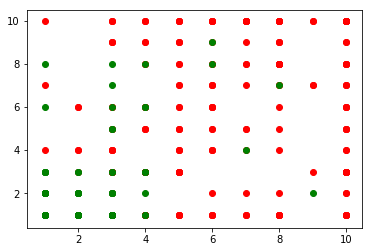

In [112]:
%matplotlib inline
plt.scatter(mal['uniformity_cell_size'],mal['normal_nucleoli'],c='red')
plt.scatter(ben['uniformity_cell_size'],ben['normal_nucleoli'],c='green')

In [109]:
prediction, bias, contributions = ti.predict(clf, X_test)
print("Bias (trainset prior)", bias[0])
print("Feature contributions:")
for c, feature in zip(contributions, list(df_clean.columns.values)):
    print(feature, sum(abs(c)))

Bias (trainset prior) [0.50026508 0.49973492]
Feature contributions:
clump_thickness [0.50026508 0.50026508]
uniformity_cell_size [0.8069133 0.8069133]
uniformity_cell_shape [0.49973492 0.49973492]
marginal_adhesion [0.73219637 0.73219637]
bland_chromatin [0.50026508 0.50026508]
normal_nucleoli [0.49973492 0.49973492]
mitoses [0.50552042 0.50552042]


The largest contibutions for the test set predictions come from marginal adhesion and the uniformity of cell size.

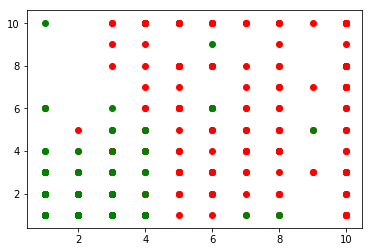

In [111]:
%matplotlib inline
plt.scatter(mal['uniformity_cell_size'],mal['marginal_adhesion'],c='red')
plt.scatter(ben['uniformity_cell_size'],ben['marginal_adhesion'],c='green')